## Description:

    Use DeSeq2 to identify differential abundance between B73 and other plant genotypes
   


# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.3’
[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.8’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.2’
[1] "ggplot2"
[1] ‘1.0.1’
[1] "gridExtra"
[1] ‘2.0.0’
[1] "scales"
[1] ‘0.3.0’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.3’
[1] "tidyr"
[1] ‘0.3.1’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.3.0’


In [4]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [6]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [8]:
%%R
#remove BARE soil controls
physeq.plant = 

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels

sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)

physeq.plant = subset_samples(physeq.Full, Plant != "BARE")

#re-order levels 
sample_data(physeq.plant)$Plant = relevel(sample_data(physeq.plant)$Plant, "B73")


## Create DeSeq2 object

# Function generating Ntreatment log2fold change figure

In [21]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Plant)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

    r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)

    TT = physeq.obj %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    return(d)
}

# Function to trim physeq object to just plant to include in Deseq analysis

        
deseq_prune = function(physeq.obj, plant) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Plant %in% c("B73", plant)), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > 0, TRUE)
    return(p.thresh)
}



In [10]:
%%R
sample_data(physeq.plant)$Plant %>% unique

 [1] 75-062 Oh7B   SETFA  MS71   ERATE  FAGES  B73    AMAPO  B97    GLYMA 
[11] H99    Il14H  SORBI  SORSUD ELCOR  ABUTH  Ki3    HELAN  Tx303  Hp301 
[21] ECHCG  Mo18  
22 Levels: B73 75-062 ABUTH AMAPO B97 ECHCG ELCOR ERATE FAGES GLYMA ... Tx303


In [31]:
%%R
Sd = sample_data(physeq.plant)
Plants = levels(Sd$Plant)[2:22]

df_all = data.frame()
df_plant = data.frame()
    
for (plant in Plants) {
        
        
        #Trim physeq object by to day-plant combo 
        physeq.p = deseq_prune(physeq.plant, plant)
    physeq.p
    }

In [33]:
%%R
sample_data(physeq.p)$Plant %>% unique

[1] 75-062 B73   
Levels: 75-062 B73


## loop through sampling dates to compare enrichment in rhizosphere to bare soil

In [34]:
%%R -w 1200 -h 600

Sd = sample_data(physeq.plant)
Plants = levels(Sd$Plant)[2:22]

df_all = data.frame()
df_plant = data.frame()
    
for (plant in Plants) {
        
        
        #Trim physeq object by to day-plant combo 
        physeq.p = deseq_prune(physeq.plant, plant)
        
        
        #convert to deseq using function above
        DF = get_Ps(physeq.p) 
   
        DF = data.frame(DF)
        DF$Plant = plant
        df_plant = rbind(df_plant, DF)     
    }


df_all = df_plant 


In [36]:
%%R
df_all %>% head


    baseMean log2FoldChange    pvalue      padj      OTU    Rank1
1  0.7037793     0.95857445 0.2610125        NA OTU.5899 Bacteria
2  2.6175394    -0.38063232 0.5138391 0.8174481 OTU.8680 Bacteria
3  1.1962488     1.01348307 0.1760730 0.5140098 OTU.2666 Bacteria
4 10.2572153    -0.33790840 0.3633213 0.7102986  OTU.323 Bacteria
5  1.3118550    -0.15269168 0.8324120 0.9531980 OTU.7636 Bacteria
6  1.8569756     0.08222738 0.9168905 0.9763042 OTU.1030 Bacteria
           Rank2               Rank3                Rank4                Rank5
1  Acidobacteria               32-21 uncultured_bacterium                 <NA>
2  Acidobacteria          Holophagae              Sva0725                 <NA>
3  Acidobacteria          Holophagae              Sva0725 uncultured_bacterium
4  Acidobacteria          Holophagae              Sva0725                 <NA>
5  Acidobacteria          Holophagae              Sva0725                 <NA>
6 Proteobacteria Deltaproteobacteria    Desulfobacterales       

In [37]:
%%R
df_all$padj %>% range %>% print
df_all %>% dim %>% print
df_all$padj%>% unique %>% length

[1] NA NA
[1] 103081     14
[1] 24492


In [38]:
%%R -i workDir


write.csv(df_all, file = "/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/l2f_B73vsGenotype.csv", row.names = FALSE, sep = ",")

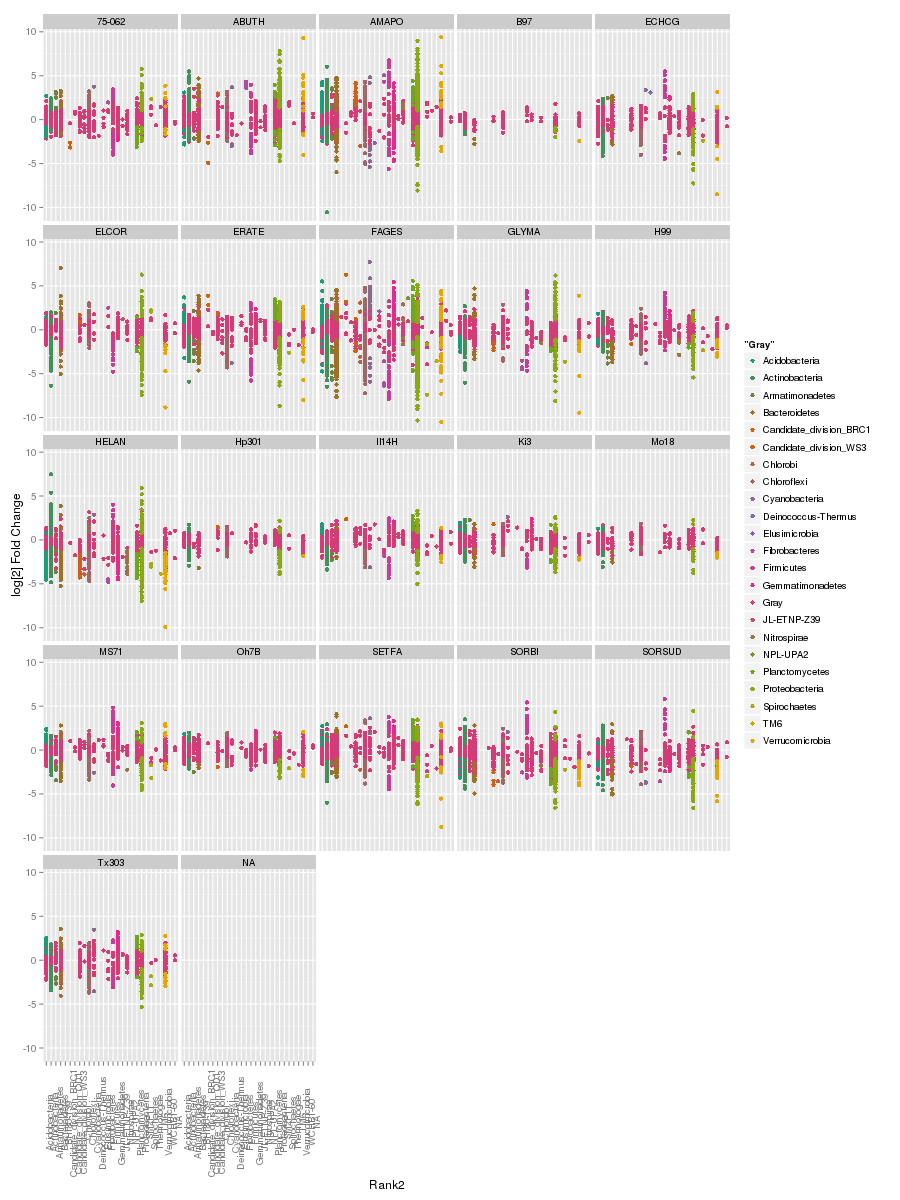

In [39]:
%%R -w 900 -h 1200

colourCount = length(unique(df_all$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

df.adj = df_all[!is.na(df_all$padj),]
df.sig = df_all[df_all$padj < .05,]
df.ns = df_all[df_all$padj >= .05,]

p = ggplot(df_all)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "Gray", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
               #geom_hline(y_intercept = .4) +
    
    facet_wrap(~Plant)+
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)
#p = p + theme_bw()




#p = p + geom_hline(y = l2fc.threshold)



#p = p + theme(axis.text.x = element_blank())

#p = p + labs(x = "Phylum", color = "Phylum")

#p = p + guides(col = guide_legend(ncol = 2))

#p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

#p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p    
    

In [58]:
%%R
##saving figure
pdf(file = "/home/bryan/RhizCG/figures/NposEnriched_byPlant.pdf", width=9, height=8)
print(p)
dev.off()

png 
  2 


In [63]:
%%R
df.sig

            baseMean log2FoldChange       pvalue         padj       OTU
NA                NA             NA           NA           NA      <NA>
NA.1              NA             NA           NA           NA      <NA>
NA.2              NA             NA           NA           NA      <NA>
NA.3              NA             NA           NA           NA      <NA>
NA.4              NA             NA           NA           NA      <NA>
NA.5              NA             NA           NA           NA      <NA>
NA.6              NA             NA           NA           NA      <NA>
NA.7              NA             NA           NA           NA      <NA>
NA.8              NA             NA           NA           NA      <NA>
NA.9              NA             NA           NA           NA      <NA>
NA.10             NA             NA           NA           NA      <NA>
NA.11             NA             NA           NA           NA      <NA>
NA.12             NA             NA           NA           NA   

In [116]:
%%R
## Check analysis by plant against whole rhizosphere dataset
 
    diagdds = phyloseq_to_deseq2(physeq.plant, ~Plant:Rep + Treatment)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

    r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    

In [117]:
%%R
summary(r)
    


out of 4981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 139, 2.8% 
LFC < 0 (down)   : 60, 1.2% 
outliers [1]     : 0, 0% 
low counts [2]   : 249, 5% 
(mean count < 0.1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [118]:
%%R
df = as.data.frame(r[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

   baseMean log2FoldChange      pvalue      padj      OTU    Rank1
1 0.2060284      0.1320320 0.685586495 0.9143730 OTU.5899 Bacteria
2 2.2028300     -0.4555403 0.021669857 0.2513396 OTU.8680 Bacteria
3 0.6566916      0.1319411 0.591479581 0.8741041 OTU.2666 Bacteria
4 6.2462284     -0.4059137 0.005076052 0.1127694  OTU.323 Bacteria
5 0.8990901      0.1665857 0.470521860 0.8194823 OTU.7636 Bacteria
6 1.0984479     -0.2092609 0.417845104 0.7921647 OTU.1030 Bacteria
           Rank2               Rank3                Rank4                Rank5
1  Acidobacteria               32-21 uncultured_bacterium                 <NA>
2  Acidobacteria          Holophagae              Sva0725                 <NA>
3  Acidobacteria          Holophagae              Sva0725 uncultured_bacterium
4  Acidobacteria          Holophagae              Sva0725                 <NA>
5  Acidobacteria          Holophagae              Sva0725                 <NA>
6 Proteobacteria Deltaproteobacteria    Desulfobacterales

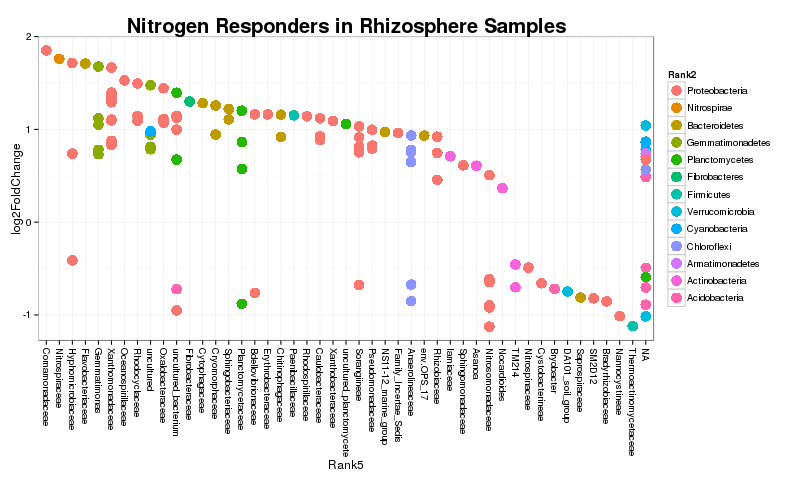

In [131]:
%%R -w 800
sigtab = d[d$padj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + 
    geom_point(size=5) + 
    ggtitle("Nitrogen Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [135]:
%%R
sigtab$OTU %>% unique %>% length

[1] 122


In [134]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/Ntreatment_AllRhizospheres.pdf", height = 6, width = 8)
print(p)
dev.off()

png 
  2 
